# Kp prediction evaluation

## Import packages

In [34]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_arch.RNN import RNN
from Datasets.SolarWind_Kp import SolarWind_Kp_TestDataset
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.utilities.model_summary import ModelSummary

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch.nn as nn

## Sub-functions

In [35]:
def denormalize(signal):
        min_max = pd.read_csv('./Data/normalized_min_max_data.csv').values
        n = signal.shape[0]
        output_signal = np.zeros_like(signal, dtype=float)
        for sample_num in range(n):
            output_signal[sample_num] = signal[sample_num] * (min_max[3][0] - min_max[3][1]) + min_max[3][1]
        return output_signal

## Set up

In [36]:
def evaluate(test_file_name,preprocess_approach,model_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # version_25/checkpoints/epoch=00029-val_loss=0.00276485.ckpt
    # version_29/checkpoints/epoch=00051-val_loss=0.00425131.ckpt
    # version_30/checkpoints/epoch=00120-val_loss=0.00970660.ckpt

    model = RNN.load_from_checkpoint(f"./Logs/RNN/train/LAST/{model_path}").eval().to(device)
    summary = ModelSummary(model, max_depth=-1)
    print(summary)
    config = {     
        'batch_size': 64,
        'n_past': 1
    }
    test_file_name = test_file_name
    normalized_data_file_path = './Data/normalized_min_max_data.csv'
    preprocess_approach = preprocess_approach
    test_dataset = SolarWind_Kp_TestDataset(test_file_name,normalized_data_file_path,config['n_past'],preprocess_approach)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    GT_ = []
    prediction = []
    with torch.no_grad():
        for input,GT in test_loader: 
            input = input.to(device)
            GT_  += GT.unsqueeze(0)
            prediction  += model(input).unsqueeze(0)
    GT_ = torch.concat(GT_).cpu()
    print(GT_.shape)
    prediction = torch.concat(prediction).cpu()
    if preprocess_approach == "normalize":
        GT_ = denormalize(GT_)
        prediction = denormalize(prediction)
    return GT_,prediction

In [42]:
test_file_name = './Data/Predicted_SDT (7).csv'
preprocess_approach = "normalize"
model_path = "version_12/checkpoints/epoch=00068-val_loss=0.00131289.ckpt"
GT_,prediction = evaluate(test_file_name,preprocess_approach,model_path)

  | Name          | Type     | Params | In sizes   | Out sizes                                    
--------------------------------------------------------------------------------------------------------
0 | RNN_base      | RNN_base | 8.4 M  | [16, 1, 4] | [16, 24]                                     
1 | RNN_base.lstm | LSTM     | 8.4 M  | [16, 1, 4] | [[16, 1, 1024], [[4, 16, 512], [4, 16, 512]]]
2 | RNN_base.fc   | Linear   | 24.6 K | [16, 1024] | [16, 24]                                     
--------------------------------------------------------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.784    Total estimated model params size (MB)


Processing: 100%|██████████| 2310/2310 [00:00<00:00, 53355.89it/s]

Done normalizing data!!!
torch.Size([2285, 24])


In [43]:
GT_.shape,prediction.shape

((2285, 24), (2285, 24))

## Numerical evaluation

In [44]:
print(f"MSE of biLSTM: {mean_squared_error(GT_, prediction):.3E}")
rmse_biLSTM = np.sqrt(mean_squared_error(GT_, prediction))
print(f"RMSE of biLSTM: {rmse_biLSTM:.3E}")
nrmse_biLSTM= rmse_biLSTM / (GT_.max() - GT_.min())
print(f"NRMSE of biLSTM: {nrmse_biLSTM*100:.2f} %")
print(f'R2 score: {r2_score(GT_, prediction)}')

MSE of biLSTM: 9.499E-01
RMSE of biLSTM: 9.746E-01
NRMSE of biLSTM: 7.38 %
R2 score: 0.8840290413914089


## Visualization

### Model prdicted results

Text(0.02, 0.5, '$Kp$')

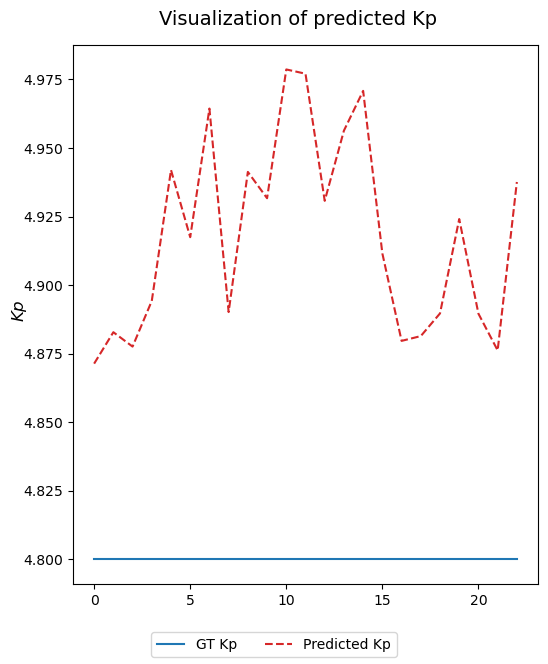

In [45]:
# For first sample in the test set
fig, axes = plt.subplots(1, 1, figsize=(6,7), sharex=True)
sample_num = 100
length = -1
start_idx = 0

line1 = axes.plot(range(len(GT_[0,:length])), GT_[0,:length], color="tab:blue", label="GT Kp")
line2 = axes.plot(range(len(prediction[0,:length])), prediction[0,:length], color="tab:red", linestyle='dashed', label="Predicted Kp")

fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
fig.suptitle('Visualization of predicted Kp', fontsize=14, y=0.93)
fig.supylabel(r'$Kp$', x=0.02)

# plt.savefig(f"./pic/acc_residual_prediction.svg", bbox_inches='tight')
# plt.savefig(f"./pic/acc_residual_prediction.png", bbox_inches='tight', dpi=500)

### Scatter plot

Text(0.02, 0.5, 'Predicted Data')

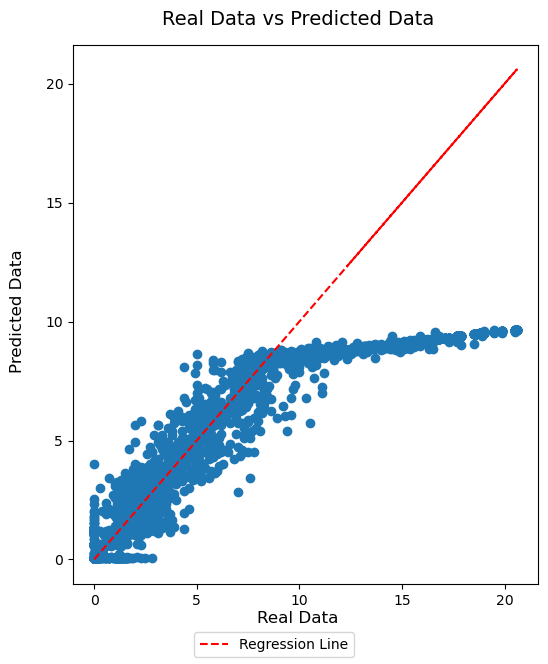

In [51]:
# For first sample in the test set
fig, axes = plt.subplots(1, 1, figsize=(6,7), sharex=True)
length = -1
# i = dof

regression_line = 1 * GT_[:length] + 0
reg_line = axes.plot(GT_[:length], regression_line, color='r', linestyle='dashed', label='Regression Line')
scatter = axes.scatter(GT_[:length],prediction[:length])
fig.legend(handles =[reg_line[0]], loc ='lower center', ncol=4)
fig.suptitle('Real Data vs Predicted Data', fontsize=14, y=0.93)
fig.supxlabel(r'Real Data', y=0.05)
fig.supylabel(r'Predicted Data', x=0.02)

# plt.savefig(f"./pic/acc_residual_prediction.svg", bbox_inches='tight')
# plt.savefig(f"./pic/acc_residual_prediction.png", bbox_inches='tight', dpi=500)

### Residual plot

Text(-0.02, 0.5, 'Residual')

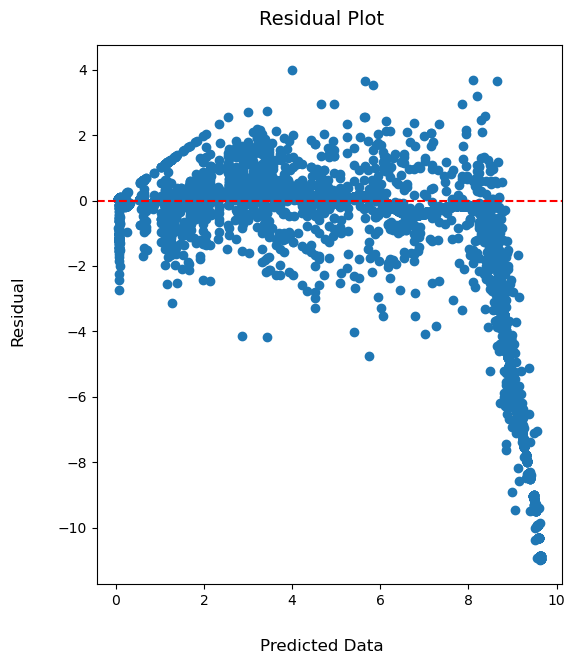

In [52]:
# For first sample in the test set
fig, axes = plt.subplots(1, 1, figsize=(6,7), sharex=True)
length = -1

residuals = prediction[:length] - GT_[:length]
line = axes.axhline(y=0, color='r', linestyle='--')
scatter = axes.scatter(prediction[:length],residuals)
fig.suptitle('Residual Plot', fontsize=14, y=0.93)
fig.supxlabel(r'Predicted Data')
fig.supylabel(r'Residual', x=-0.02)

# plt.savefig(f"./pic/acc_residual_prediction.svg", bbox_inches='tight')
# plt.savefig(f"./pic/acc_residual_prediction.png", bbox_inches='tight', dpi=500)

## Predict next 24 hours' Kp 

In [1]:
def scale_array_to_range(array, new_min=0, new_max=9):
    min_val = np.min(array)
    max_val = np.max(array)
    scaled_array = (array - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return scaled_array

scaled_array = scale_array_to_range(prediction, new_min=0, new_max=9)
prediction = scale_array_to_range(prediction, new_min=0, new_max=9)
prediction = prediction.tolist()
prediction = [item for sublist in prediction for item in sublist]
GT_ = scale_array_to_range(GT_, new_min=0, new_max=9)
GT_ = GT_.tolist()
GT_ = [item for sublist in GT_ for item in sublist]

def hours_to_days_hours(hours):
    days = hours // 24
    remaining_hours = hours % 24
    return days, remaining_hours

def detect_geomagnetic_storm(scaled_array):
    storm_detected = False
    storm_start = None
    storm_duration = 0

    for i, value in enumerate(scaled_array):
        if value[0] > 5:
            if not storm_detected:
                storm_detected = True
                storm_start = i
            storm_duration += 1
        else:
            if storm_detected:
                storm_detected = False
                detected_day, detected_remaining_hours = hours_to_days_hours(storm_start+1)
                storm_day, storm_remaining_hours = hours_to_days_hours(storm_duration)
                print(f"Geomagnetic storm detected after {detected_day:5d} days and {detected_remaining_hours+1:3d} hours and will continue {storm_day:3d} days {storm_remaining_hours:3d} hours\n")
                storm_duration = 0

detect_geomagnetic_storm(scaled_array)


NameError: name 'prediction' is not defined

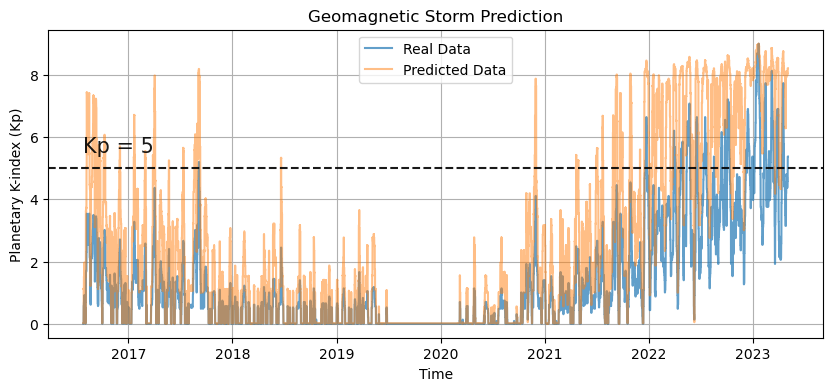

In [69]:
df_test = pd.read_csv(test_file_name)
timestamps = df_test['Time'].values.tolist()

from datetime import datetime, timedelta

utc_times = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps][24:]
plt.figure(figsize=(10, 4))
plt.plot(utc_times, GT_, label="Real Data",alpha = 0.7)
plt.plot(utc_times, prediction, label="Predicted Data",alpha = 0.5)
plt.axhline(y=5, color='black', linestyle='--',alpha = 0.9)
# fontsize =12
plt.text(utc_times[0], 5.5, 'Kp = 5', fontsize = 15,alpha = 0.9)
plt.xlabel('Time')
plt.ylabel('Planetary K-index (Kp)')
plt.legend()
plt.title("Geomagnetic Storm Prediction")
plt.grid(True)
plt.show()
